# Coursework 2: Generative Models

#### Instructions

Please submit on CATe a zip file named *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question.
2. Your trained models as *VAE_model.pth, DCGAN_model_D.pth, DCGAN_model_G.pth*

#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 27th February, 2020**

### Setting up working environment

For this coursework you, will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so.

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1 (50 points)
1. For the first part, you are asked to implement a Variational Autoencoder on the MNIST dataset. You will be assesed by the following:
    - **loss function and proper explanations**. You will have to choose the right loss function by properly modelling the probability distributions involved. There are more than one accepted approaches. 
    - **reconstruction error**. You will need to achieve a low enough error in order to reconstruct the images of the dataset with relatively high fidelity. You will have to provide us with your best model's training and test loss curves (both the total loss and each individual term), a few reconstructed images and a few sampled images from the latent space of the VAE in the respective cells.
    - **qualitative results**. You have to provide us with certain qualitative results that are usually used to assess the quality of the learned representations (more info below)

 
## Part 2 (50 points)
2. For the DCGAN, The success of your models will be tested as follows:
    - **By the model's training error**. You will need to achieve relatively balanced errors for the generator and the discriminator of your model in order to sample realistic images from the generator. You will have to provide us with your best model's training losses curves, a discussion on how you concluded to the chosen architecture, and visualizations of generated samples in the respective cells. Your results do not have to be perfect, however a good discussion on the choice of architecture will be valued.
    - **By avoiding mode collapse**. A common problem of training GANs is that they end up generating only a few different samples (if not only one), rather than learning the whole distribution of the training data. This problem is referred to as mode collapse. You will need to make a discussion on whether you noticed mode collapse or not during your experimentation and if yes, how you addressed it.

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture. You are free to choose either Multilayer Perceptrons (MLPs) or Convolutional Layers

You will need to define:
*  The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward

b. Design an appropriate loss function. There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training.


In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_VAE/MNIST'):
    os.makedirs('./CW_VAE/MNIST')


cuda:0


## Hyper-parameter selection

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose the number of epochs, the learning rate and the batch size
num_epochs = 10
learning_rate  =  0.001
batch_size = 128
### Choose a value for the size of the latent space
latent_dim = 10

###

# Define here the any extra hyperparameters you used.

###

# Modify this line if you need to do any input transformations (optional).
transform = transforms.Compose([
     transforms.ToTensor()
])

# Modify the denorm function in case you need to do any output transformation when visualizing your images

denorm = lambda x:x



## Data loading


In [0]:
train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True, num_workers=16)
loader_test = DataLoader(test_dat, batch_size, shuffle=False, num_workers=16)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]

save_image(fixed_input, './CW_VAE/MNIST/image_original.png')


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


## Model Definition

In [0]:
# *CODE FOR PART 1.1a IN THIS CELL*

from torch.autograd import Variable

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        self.forward_1 = nn.Linear(784, 400)
        self.forward_2_1 = nn.Linear(400, latent_dim) # used for finding mu
        self.forward_2_2 = nn.Linear(400, latent_dim) # used for finding logvar
        self.forward_3 = nn.Linear(latent_dim, 400)
        self.forward_4 = nn.Linear(400, 784)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        hidden_1 = F.relu(self.forward_1(x))
        return self.forward_2_1(hidden_1), self.forward_2_2(hidden_1)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

        
    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        hidden_3 = F.relu(self.forward_3(z))
        return torch.sigmoid(self.forward_4(hidden_3))
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
model = VAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 640804
VAE(
  (forward_1): Linear(in_features=784, out_features=400, bias=True)
  (forward_2_1): Linear(in_features=400, out_features=10, bias=True)
  (forward_2_2): Linear(in_features=400, out_features=10, bias=True)
  (forward_3): Linear(in_features=10, out_features=400, bias=True)
  (forward_4): Linear(in_features=400, out_features=784, bias=True)
)


In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Training loop

In [0]:
# *CODE FOR PART 1.1b IN THIS CELL*

### Make loss correct. Doesn't matter if its big. make beta better ###

def loss_function_VAE(recon_x, x, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        log_likelihood = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction = 'sum')
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        beta = 1

        return (log_likelihood + beta*kld) # /batch_size
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
model.train()
loss_plot_tr = []
kld_plot_tr = []
log_likelihood_loss_plot_tr = []
for epoch in range(num_epochs):     
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        train_loss = 0
        kld_loss = 0
        log_likelihood_loss = 0
        for batch_idx, data in enumerate(loader_train):
            img, _ = data
            img = img.view(img.size(0), -1)
            img = img.to(device)
            optimizer.zero_grad()
            # forward
            recon_batch, mu, logvar = model(img)
            loss = loss_function_VAE(recon_batch, img, mu, logvar)
            # backward
            loss.backward()
            train_loss += loss.item()
            kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            log_likelihood = F.binary_cross_entropy(recon_batch, img.view(-1, 784), reduction = 'sum')
            kld_loss += kld
            log_likelihood_loss += log_likelihood
            optimizer.step()

        loss_plot_tr.append(train_loss/ len(loader_train.dataset))
        # kld = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / len(loader_test.dataset)
        # bce = F.binary_cross_entropy(recon_batch, img.view(-1, 784), reduction = 'sum') / len(loader_test.dataset)
        kld_plot_tr.append(kld_loss / len(loader_train.dataset))
        log_likelihood_loss_plot_tr.append(log_likelihood_loss / len(loader_train.dataset))
        # print out losses and save reconstructions for every epoch
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss / len(loader_train.dataset)))
        recon = model(fixed_input.view(fixed_input.size(0), -1).to(device))[0]
        recon = denorm(recon.cpu())
        save_image(recon, 'reconstructed_epoch_{}.png'.format(epoch))
        # save_image(recon, './cw2_VAE/reconstructed_epoch_{}.png'.format(epoch))
        # save the model
        torch.save(model.state_dict(), 'model.pth')
        # torch.save(model.state_dict(), './cw2_VAE/model.pth')
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

# save the model
torch.save(model.state_dict(), './CW_VAE/MNIST/VAE_model.pth')

# save the model to google drive so I can submit to cate
# model_save_name_VAE = 'VAE_model.pth'
# path = F"/content/gdrive/My Drive/{model_save_name_VAE}"
# torch.save(model.state_dict(), path)


epoch [1/10], loss:161.9233
epoch [2/10], loss:124.7875
epoch [3/10], loss:119.5874
epoch [4/10], loss:117.0095
epoch [5/10], loss:115.3571
epoch [6/10], loss:114.1831
epoch [7/10], loss:113.2570
epoch [8/10], loss:112.4809
epoch [9/10], loss:111.8506
epoch [10/10], loss:111.2979


### Your explanations about the loss function here:

The loss function I have used for the VAE is a weighted sum of two separate parts: the log-likelihood loss and the kl divergence loss. The log-likelihood loss is only based on mu as the lecture notes state that it is common practice to ignore the standard deviation part. Therefore the log-likelihood loss is very similar to a binary cross entropy loss where we involve the mu part. The second term is the KL divergence which is given by the formula: KLD = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2). The KLD also has a weight attached to it which I have denoted as 'beta'. Additionally, we average over the whole length of the training dataset so we divide the total loss by the length. The loss is in the hundreds, which I was a bit confused about because I thought the loss would be smaller. Therefore I experimented with dividing the loss by the batch size and by altering the value of beta. Dividing the loss by the batch size took the total loss to between 1 and 0.5, which I thought was ideal, but it didn't actually affect the quality of the reconstructed data. 

## Part 1.2 (10 points)

a. Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). 

b. Provide a brief analysis of your loss curves. What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)? Can you intuitively explain if this behaviour is desirable? Have you observed posterior collapse during traing (i.e. when the KL is too small during the early stages of training)? If yes, how did you mitigate it? How did this phenomenon reflect on your output samples? 

c. Visualize a subset of the images of the test set and their reconstructions as well as a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation) .Please deliver the notebook including the outputs of the cells below.


<function matplotlib.pyplot.show>

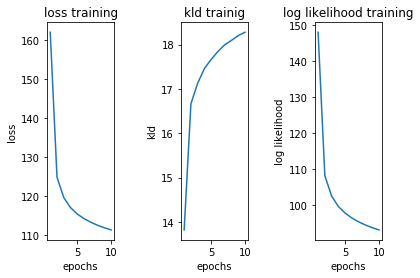

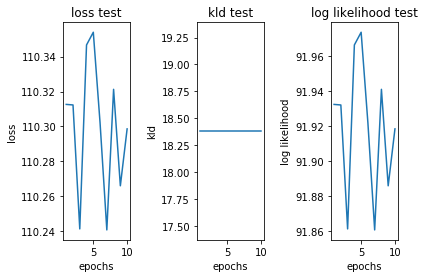

In [0]:
# *CODE FOR PART 1.2a IN THIS CELL*

import matplotlib.pyplot as plt

epochs = [1,2,3,4,5,6,7,8,9,10]

fig = plt.figure() 

plt.subplot(131)
plt.plot(epochs, loss_plot_tr)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('loss training')


plt.subplot(132)
plt.plot(epochs, kld_plot_tr)
plt.ylabel('kld')
plt.xlabel('epochs')
plt.title('kld trainig')

plt.subplot(133)
plt.plot(epochs, log_likelihood_loss_plot_tr)
plt.ylabel('log likelihood')
plt.xlabel('epochs')
plt.title('log likelihood training')

fig.subplots_adjust(hspace=.5,wspace=1) 

plt.show

#### Now do the same for test set ####

model.eval()
loss_plot_te = []
kld_plot_te = []
log_likelihood_loss_plot_te = []
for epoch in range(num_epochs):
  test_loss = 0
  kld_loss = 0
  log_likelihood_loss = 0
  with torch.no_grad():
    for batch_idx, data in enumerate(loader_test):
            img, _ = data
            img = img.view(img.size(0), -1)
            img = img.to(device)
            img = Variable(img)
            # forward
            recon_batch, mu, logvar = model(img)
            loss = loss_function_VAE(recon_batch, img, mu, logvar)
            kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            log_likelihood = F.binary_cross_entropy(recon_batch, img.view(-1, 784), reduction = 'sum')
            kld_loss += kld
            log_likelihood_loss += log_likelihood
            test_loss += loss.item()

    loss_plot_te.append(test_loss/ len(loader_test.dataset))
    kld_plot_te.append(kld_loss / len(loader_test.dataset))
    log_likelihood_loss_plot_te.append(log_likelihood_loss / len(loader_test.dataset))
    # print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, test_loss / len(loader_test.dataset)))


fig1 = plt.figure() 

plt.subplot(131)
plt.plot(epochs, loss_plot_te)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('loss test')


plt.subplot(132)
plt.plot(epochs, kld_plot_te)
plt.ylabel('kld')
plt.xlabel('epochs')
plt.title('kld test')

plt.subplot(133)
plt.plot(epochs, log_likelihood_loss_plot_te)
plt.ylabel('log likelihood')
plt.xlabel('epochs')
plt.title('log likelihood test')

fig1.subplots_adjust(hspace=.5,wspace=1) 

plt.show



### Your answer to 1.2b here:

During training, we have that the total loss decreases as we train for a longer time. Initially, the loss decreases rapidly over the first 2-3 epochs, and then starts to decrease more slowly. Additionally, we have that the log-likelihood loss loosely follows the shape of the total loss. This is because the log-likelihood loss is quite a bit larger than the KLD loss. We could change how this affets the total loss by altering our value of beta in the loss function. The log-likelihood loss decreases over time because it directly measures the performance of our classification model. As our model gets better at classifying, the log-likelihood decreases. Therefore the more we train, the more the log-likelihood goes down.  The KLD loss increases as we train for more epochs. Initially the KLD loss increases rapidly, before slowing down. This is because we are measuring the information gain, and as we train for longer the information gain increases. Therefore we have that both behaviours shown in the graphs are desirable for our model. 

In my training I have not suffered any posterior collapse during training. If I had experienced it, I would mitigate it by having an initial interval in the training where I do not consider the KLD loss. 

My output samples look pretty quality. I found that changing the 'latent dim' in the training actually affected the quality of the reconstruced and generatesd quite a lot. If I made the latent dim high then the generated samples were of lower quality and the reconstructed were of higher. If I made the latent dim low then it was the other way around. I therefore settled for a medium value of the latent dim. I don't know why this affected my results so much. 

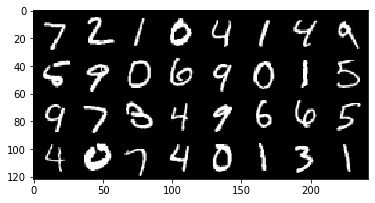

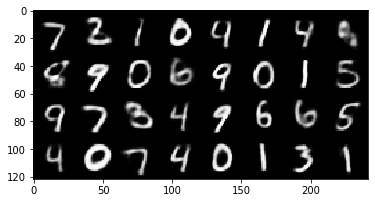

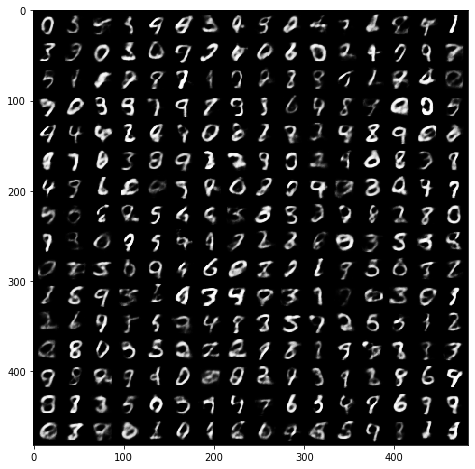

In [0]:
# *CODE FOR PART 1.2c IN THIS CELL*

# load the model
model.load_state_dict(torch.load('./CW_VAE/MNIST/VAE_model.pth'))
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch = model(fixed_input.view(fixed_input.size(0), -1).to(device))[0]
    recon_batch = recon_batch.view(-1, 1, 28, 28)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)
    
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z.view(z.size(0), -1).to(device))
    samples = samples.view(-1,1,28,28)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



## Part 1.3 (15 points)

### Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Extract the latent representations of the test set and visualize them using T-SNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) or PCA. What do you observe? Discuss the structure of the visualized representations. Please use different colours for each digit class.

b. Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

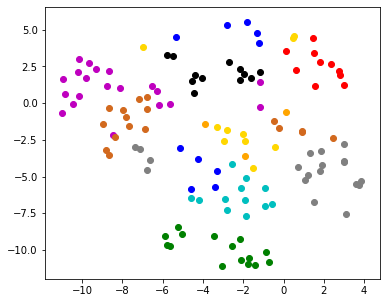

In [0]:
# *CODE FOR PART 1.3a IN THIS CELL*

from sklearn import manifold
import cv2
import torch.utils.data
import numpy as np
from sklearn.manifold import TSNE

def t_sne(size_datapoints):
    model.eval()
    with torch.no_grad():
        data = iter(loader_test)
        img, labels = data.next()
        img = img.to(device)
        img = img.cuda()
        img = Variable(img)
        recon_batch, mean, logvar = model(img) # Find mean and logvar from image
        latent_repr = model.reparametrize(mean, logvar)  # latent space representation of dataset

        tsne = TSNE(n_components=2, random_state=0) # call TSNE from sklearn manifold
        latent_repr = latent_repr.cpu() # make cpu
        latent_repr_2dim = tsne.fit_transform(latent_repr)  # Use fit_transform function from tsne to be able to graph tsne

        digits_mnist = range(0, 10)
        label = labels.detach().numpy()  # change labels into numpy format. Have to detach to use numpy()

        plt.figure(figsize=(6, 5)) # Choose a figure size for the image
        colors = 'r', 'g', 'b', 'c', 'm', 'gold', 'k', 'gray', 'orange', 'chocolate' # choose 10 different colors for each digit
        for digit, color in zip(digits_mnist, colors):  # zip creates iterator
            ind = np.where(label == digit)  # returns indices where label == digit
            plt.scatter(latent_repr_2dim[ind, 0], latent_repr_2dim[ind, 1], color=color)  

        plt.show()
        plt.close()

t_sne(len(loader_test.dataset))



### Your answer to 1.3a here:

The above graph visualises the latent representations of a batch from the test set using T-SNE. We can see that on the whole, there is an obvious clustering structure to the visualisation where each digit has its own space in the graph. We have that green digits are on the bottom, purple are top left, red top right... etc. The T-sne visualisation shows that there is a little bit of confusion between some of the digits however. For example, there are two 'purple' digits in the center of the graph that are confused with the 'black'. This is because some digits look very much like another digit, for example 7 and 1, 0 and 6, or 4 and 6. Overall, the t-sne visualisation shows a pretty clear distinction between each digit class. 

Its interesting using t-sne because if I changed the perplexity then I got some very different results. I decided to keep the perplexity to a default setting because that seemed to give the clearest distinctions between digits. Also, take into account that the resulting visualisation is not the same every time I run the code. Therefore my description above may be a bit off if the code is run again. This is because there is an issue with 'local minima': t-sne visualisation is not deterministic. 

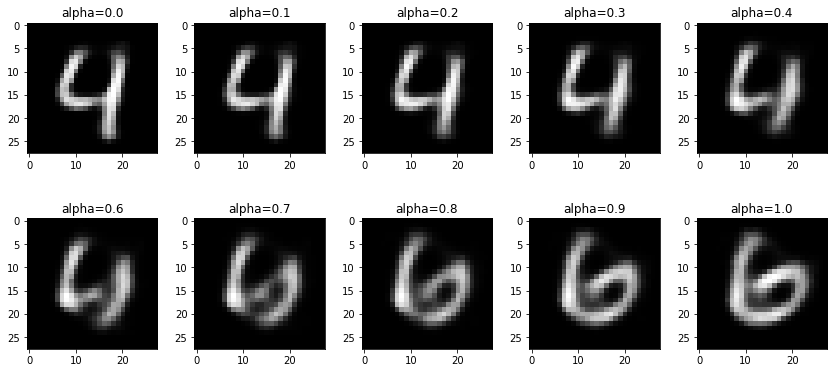

In [0]:
# *CODE FOR PART 1.3b IN THIS CELL*

# import necessary packages #

import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

# Define function to put image between values 0 and 1 for plotting

def clamp(x):
    x = x.clamp(0, 1)
    return x

# Put model in evaluation mode #

model.eval()

# Creatr function that will interpolate between two images, using encode and decode 
# from vae model 

def interpolation(alpha_interpolate, model, img1, img2):
    
    with torch.no_grad():
    
        # retrieve the latent representation from the first digit 
        img1 = img1.view(img1.size(0), -1).to(device)
        img1 = img1.cuda()
        img1 = Variable(img1)
        latent_repr_1, _ = model.encode(img1)

        # retrieve latent representation from second digit 
        img2 = img2.view(img2.size(0),-1).to(device)
        img2 = img2.cuda()
        img2 = Variable(img2)
        latent_repr_2, _ = model.encode(img2)

        # perform interpolation between the latent representations of two digits using linear interpolation formula
        latent_interpolation = alpha_interpolate * latent_repr_1 + (1- alpha_interpolate) * latent_repr_2

        # use model.decode to reconstruct the interpolated images. Also put to cpu
        image_interpolation = model.decode(latent_interpolation)
        image_interpolation = image_interpolation.cpu()

        return image_interpolation
    
# Now we want to sort the test set by digits and put them in form so we can use
# them as images in interpolation function:

# First create an empty array for the digits
digits = [[] for _ in range(10)]
# iterate through img_batch and label_batch in test set and add to digit array
for img_batch, label_batch in loader_test:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= len(loader_test.dataset):
        break;

# interpolation alphas
alpha_range = np.linspace(0,1,10)

# Adjust figure sizes

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,number in enumerate(alpha_range):
    # I chose the digits 4 and 6 to interpolate between. One can choose any digits below.
    digit2 = 4
    digit1 = 6

    image_interpolation = interpolation(float(number), model, digits[digit1][0], digits[digit2][0])
   
    image_interpolation = clamp(image_interpolation)

    image_interpolation = image_interpolation.view(-1,1,28,28)
    
    img = image_interpolation.numpy()
   
    axs[ind].imshow(img[0,0,:,:], cmap='gray')
    axs[ind].set_title('alpha='+str(round(number,1)))
plt.show() 


### Your answer to 1.3b here:

Above we have some code that shows the linear interpolation between the digit 4 and the digit 6. I found that some digits worked really well when interpolating between them, such as: 1 and 7, 3 and 8, 0 and 6, 4 and 6. This is because these digits were similar enough that the change in the original digit towards the target digit as my value of alpha increases is very clear and aesthetic. For example, for the change between 4 and 6 we can see how the 'tail' of the 4 slowly recedes, the top right part of the 4 curls around to make the body of the 6, and the top left part curls to make the top part of the six. This is all very clear and easy to see how the two digits change into one another. 

However, if we choose two digits that don't look alike at all we have that midway through the interpolation there is just a blurry blob on the image. The interpolation is not clear and obvious, therefore the original image has to become a blurry blob before it can transition into the new image. 

## Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse. 

_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get full marks. The attached model does not have to be perfect._

### Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

b. visualize images sampled from your best model's generator.

c. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).

For b. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_DCGAN'):
    os.makedirs('./CW_DCGAN')

cuda:0


### Data loading

In [2]:
batch_size = 64  
NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_dir = './datasets'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


### Hyper-parameter selection

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*

### Choose the number of epochs, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 30
learning_rate  = 0.001
img_dim_size = 32
latent_vector_size = 100
channels = 3 # set channels = 3 as any other value doesn't seem to work

# could add in hyperparameters to use below #
###

# Define here other hyperparameters that you used.

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.init_size = img_dim_size // 4

        self.forward_layer = nn.Sequential(nn.Linear(latent_vector_size, 128 * self.init_size ** 2))

        self.convolution_layers = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = self.forward_layer(z)
        x = x.view(x.shape[0], 128, self.init_size, self.init_size)
        x = self.convolution_layers(x)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return x

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        def disc_convolution_block(in_filters, out_filters, add_batch_norm=True):
            convolution_layer = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.2)]
            if add_batch_norm:
                convolution_layer.append(nn.BatchNorm2d(out_filters, 0.8))
            return convolution_layer

        self.net = nn.Sequential(
            *disc_convolution_block(channels, 16, add_batch_norm=False),
            *disc_convolution_block(16, 32),
            *disc_convolution_block(32, 64),
            *disc_convolution_block(64, 128),
        )

        downsampled_size = img_dim_size // 16

        self.layer_adversarial = nn.Sequential(nn.Linear(128 * downsampled_size ** 2, 1), nn.Sigmoid())
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def discriminator(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.net(x)
        out = out.view(out.shape[0], -1)
        out = self.layer_adversarial(out)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        return out

    def forward(self, x):
        out = self.discriminator(x)
        return out.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [15]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 1051139
Generator(
  (forward_layer): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (convolution_layers): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)


Total number of parameters in Discriminator is: 98401
Discriminator(
  (net): Se

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [0]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

### Define fixed input vectors to monitor training and mode collapse.

In [0]:
## Note: I changed the size of fixed_noise so that it fits my network architecture. 
# If I didn't change it I struggled to alter the latent_vector_size and 
# therefore I got mode collapse. 

fixed_noise = torch.randn(batch_size, latent_vector_size, device=device)
# fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [20]:
## Note: I changed the size of noise and input_noise so that it fits my network architecture. 
# If I didn't change it I struggled to alter the latent_vector_size and 
# therefore I got mode collapse. 

train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    train_loss_D = 0 # put the loss before each epoch
    train_loss_G = 0
    for i, data in enumerate(loader_train, 0):
        # train_loss_D = 0
        # train_loss_G = 0
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################device
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, device=device)
        # noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        # model_save_name_real = 'real_samples.png'
        # path_real = F"/content/gdrive/My Drive/{model_save_name_real}"
        # torch.save(denorm(real_cpu.cpu()).float(), path_real)
        save_image(denorm(real_cpu.cpu()).float(), './CW_DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()).float(), './CW_DCGAN/fake_samples_epoch_%03d.png' % epoch)
    # model_save_name_fake = 'fake_samples_epoch_%03d.png'
    # path_fake = F"/content/gdrive/My Drive/{model_save_name_fake}"
    # torch.save(denorm(fake.cpu()).float(), path_fake)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

torch.save(model_G.state_dict(), './CW_DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './CW_DCGAN/DCGAN_model_D.pth')

# Save to google drive path so I can submit to cate
            
# model_save_name_DCGAN_model_G = 'DCGAN_model_G.pth'
# model_save_name_DCGAN_model_D = 'DCGAN_model_D.pth'
# path_G = F"/content/gdrive/My Drive/{model_save_name_DCGAN_model_G}"
# path_D = F"/content/gdrive/My Drive/{model_save_name_DCGAN_model_D}"

# torch.save(model_G.state_dict(), path_G)
# torch.save(model_D.state_dict(), path_D)


[0/5][0/766] Loss_D: 1.3832 Loss_G: 0.7061 D(x): 0.4972 D(G(z)): 0.4954 / 0.4937
[0/5][1/766] Loss_D: 1.3894 Loss_G: 0.7026 D(x): 0.4957 D(G(z)): 0.4971 / 0.4954
[0/5][2/766] Loss_D: 1.3783 Loss_G: 0.7051 D(x): 0.4996 D(G(z)): 0.4954 / 0.4942
[0/5][3/766] Loss_D: 1.3864 Loss_G: 0.7039 D(x): 0.4989 D(G(z)): 0.4988 / 0.4948
[0/5][4/766] Loss_D: 1.3738 Loss_G: 0.7149 D(x): 0.5000 D(G(z)): 0.4933 / 0.4895
[0/5][5/766] Loss_D: 1.3842 Loss_G: 0.7099 D(x): 0.4971 D(G(z)): 0.4957 / 0.4919
[0/5][6/766] Loss_D: 1.3779 Loss_G: 0.7040 D(x): 0.5020 D(G(z)): 0.4975 / 0.4948
[0/5][7/766] Loss_D: 1.3766 Loss_G: 0.7000 D(x): 0.5009 D(G(z)): 0.4956 / 0.4970
[0/5][8/766] Loss_D: 1.3788 Loss_G: 0.7098 D(x): 0.4985 D(G(z)): 0.4942 / 0.4920
[0/5][9/766] Loss_D: 1.3908 Loss_G: 0.7017 D(x): 0.4959 D(G(z)): 0.4976 / 0.4960
[0/5][10/766] Loss_D: 1.4004 Loss_G: 0.6852 D(x): 0.4968 D(G(z)): 0.5034 / 0.5041
[0/5][11/766] Loss_D: 1.3845 Loss_G: 0.6934 D(x): 0.5067 D(G(z)): 0.5055 / 0.5000
[0/5][12/766] Loss_D: 1.40

In [0]:
# DISCUSS THE SELECTION OF THE ARCHITECTURE IN THIS CELL*



I will break down my final selection of the DC-GAN architecture by going through the different architectures that I tried and how I came to my final decision. 

Architecture 1: my original architecture followed the recommendation given in the notebook as I chose to mirror the model I took for my VAE. Therefore, for the discriminator I had two forward Linear layers where the hidden layer had a RelU activation function. The generator also had two forward Linear layers, where the hidden layer had a RelU activation function and the final layer had a sigmoid activation function. This was a much too simple model to effectively generate new images from noise. This is due to many things - firstly I had no batch normalisation included, secondly I had no dropout included, thirdly I did not have enough layers, fourthly I had the wrong activation functions for each layer, fifthly I have not added any upsampling, and lastly I wasn't using an convolutional layers in my network. Therefore my experimentation tried to deal with each of these issues one step at a time. 

Architecture 2: For my second archiecture I added convolutional layers into both the discriminator and the generator. Therefore, for the generator I initialised the input with a Linear layer, before passing the Linear layer through two convolutional layers that both had ReLU activation functions. For the discriminator I had 3 convolutional layers that then got passed to a Linear layer with a Sigmoid activation function. This architecture worked better than the architecture before, but the loss graphs didn't look great and the images I managed to generate were kind of nonsense. Also it took a very long time to train this architecture on the data. 

Architecture 3: For my 3rd attempt I added batch normalisation after every convolutional layer in the network. This was nice because it sped up the training, but it didn't really do much to affect the quality of the generated images. 

Architecture 4: My 4th attempt involved using different activation functions. Instead of using ReLU as the activation function in the hidden layers of both the generator and the discriminator, I decided to use LeakyReLU. Additionally, for the final layer of the generator I used a tanh activation function, and for the final layer of the discriminator I used a sigmoid activation function, as proposed by the paper provided by Radford and Metz. This very much helped the stability of the neural network and the loss functions looked better. Additionally, the generated images started to resemble something that I was after. 

Architecture 5: For my 5th attempt I decided to increase the number of layers in both my generator and my discriminator. Before I was using 2 convolutional layers for the generator and 3 for the discriminator. This time I decided to use 3 for the generator and 4 for the discriminator. This was very good for my image generation and made them a bit clearer. 

Architecture 6: Lastly I decided to use Upsampling in the generator. I only used it once, just before the first convolutional layer in the generator. I also added in Dropout after most convolutional layers to prevent overfitting. 

Architecture 6 was my final fully built network. It works quite well in generating new images, and the images do resemble the original images in terms of colours and spacing. However, the generated images are still blurry and one can't really make out what the images are trying to convey. Maybe a few additional layers would make this better. Also, I only trained the model for 30 epochs, so if I trained for say 100 epochs then we might get amazing generated images. I believe that the architecture is definitely along the right track. 

### Generator samples

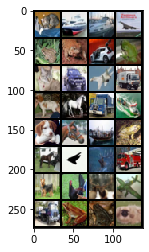

In [0]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

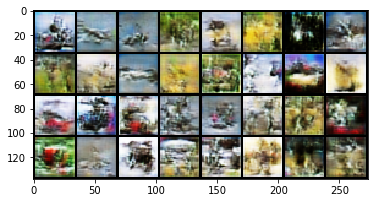

In [0]:
# load the model
model_G.load_state_dict(torch.load('./CW_DCGAN/DCGAN_model_G.pth'))
# input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
input_noise = torch.randn(batch_size, latent_vector_size, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

### Part 2.2 (10 points)

### Train losses curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

The code for generating the plot is already given. Make sure that the version of the notebook you deliver includes these results.

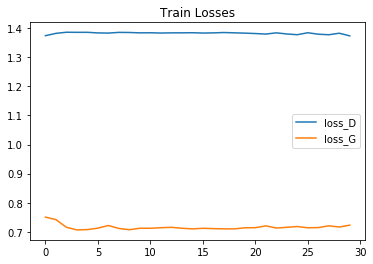

In [0]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='loss_D')
plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()

In [0]:
# ANSWER FOR PART 2.2 IN THIS CELL*


The loss for the discriminator and generator seem to be theoretically sensible. The generator loss is good because it decreases steadily for the first few epochs and then settles around a loss value of around 0.72, which is a good loss value for a generator model to have. The discriminator loss however is pretty constant throughout training at a value of around 1.4. I am surprised that the loss for the discriminator is not lower, however I have read that improvements to the generator comes at the expense of the discriminator. So maybe my generator generalises to the data extremely well, but the architecture is too good for the generator therefore affects the discriminator negatively. It is great that there are no oscillations present in the loss for the generator, as this could imply that we have had mode collapse. I would like to get the loss for the discriminator lower. Maybe if we trained the model for around 300 epochs then we would see a change in the loss curves. I would expect the loss for the discriminator to decrease after around epoch 50-100 and then settle at a lower value. 

### Part 2.3 (10 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

In [0]:
# ANSWER FOR PART 2.3 IN THIS CELL*


I did have mode collapse when I tried to run my code with a small latent dimension (I started with a latent dimension of 1). I could tell that I had mode collapse because the loss of my generator model oscillated while the model was training and the loss also increased. Also, in the images created by my generator I only had about 4 or 5 unique images created out of a subset of 32. I think this behaviour is attributed to the latent dimension. When the latent dimension is small mode collapse is much more likely to happen. To cope with mode collapse I increased my latent dimension in my network to 100. To do this and also make my network accept it I had to change the size of the input_noise, fixed_noise and noise vectors that are used to generate images / train the network. I hope this is OK to do. I then had to change the size of the noise vectors such that they matched the size of the latent dimension of my network, otherwise I got a size mismatch in matrix multiplication. This seems to have fixed the issue and now when I look at generated images I get almost 32 unique generated images everytime out of a subset of 32. It is easy to notice mode collapse as a lot of the generated images look the same. This was how I identified that my model had mode collapse. Increasing the latent dimension was how I fixed it and coped with the issue. A latent dimension of 100 fixed the issue. 